In [1]:
from sklearn import tree, metrics
import pandas as pd
from sklearn import model_selection
import matplotlib.pyplot as plt
import graphviz
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import learning_curve

## Build a Decision Tree Classifier

The following method accepts a few model and hyper-parameter values and returns a decision tree.

In [2]:
def dt_train(X, y, **kwargs):
    max_depth = kwargs.get('max_depth', None)
    random_state = kwargs.get('random_state',7)
    criterion = kwargs.get('criterion', 'gini')
    min_impurity_split = kwargs.get('min_impurity_split', 0)
    ccp_alpha = kwargs.get('alpha', 0.0)
    balance = kwargs.get('balance')
    
    dt = tree.DecisionTreeClassifier(max_depth=max_depth, random_state=random_state, criterion='entropy', 
                                     class_weight=balance, ccp_alpha=ccp_alpha, min_impurity_split=min_impurity_split)
    dt.fit(X, y)
    return dt

The following method accepts a decision tree classification model and perform post pruning

In [3]:
def prune(dt, X, y):
    path = dt.cost_complexity_pruning_path(X, y)
    return path

## Utilities for analysis

The following method builds a validation curve for a decision tree classification model based on a set of model and hyperparameter values. 

In [23]:
def plot_validation_curve(dt, X, y, param_name, param_range, cross_validation=5, fig_name="validation_curve.png",
                          xscale='linear', scorer=None):
    tr_sc, tst_sc = model_selection.validation_curve(dt, X, y, param_name=param_name,
                                                            param_range=param_range, cv=cross_validation,
                                                    scoring=scorer)
    plt.figure()
    plt.xticks(param_range)
    plt.xlabel(param_name)
    plt.xscale(xscale)
    plt.ylabel("Score")
    plt.plot(param_range, np.mean(tr_sc, axis=1), label='Training score')
    plt.plot(param_range, np.mean(tst_sc, axis=1), label='Cross-validation score')
    plt.legend(loc="best")
    plt.title('Decision Tree - Validation Curve')
    
    plt.savefig(fig_name)
    plt.show()
    return np.mean(tst_sc, axis=1)


Get classification score

In [46]:
def get_classification_score(dt, X, y):
    return dt.score(X, y)

def get_f1_score(dt, X, y):
    yp = dt.predict(X)
    return metrics.f1_score(y, yp, average="macro")

The following function provides a visual representation for the decision tree

In [6]:
def visualize_dt(dt, feature_names, target_names):
    exp_tree = tree.export_graphviz(dt, out_file=None, 
                      feature_names=feature_names,  
                      class_names=target_names,  
                      filled=True, rounded=True)
    return graphviz.Source(exp_tree)
    

## Census Data Analysis
Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))

Prediction task is to determine whether a person makes over 50K a year.

In [7]:
data = pd.read_csv("adult.data", sep='\t', header=None, 
                   names=["age", "workclass", "fnlwgt", "education", 
                          "education-num", "marital-status", "occupation",
                          "relationship", "race", "sex", "capital-gain", 
                          "capital-loss", "hours-per-week", "native-country", 
                          "output"])
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,output
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Now, let us take a look at the number of samples for each of the discrete output values. 

<AxesSubplot:xlabel='output', ylabel='count'>

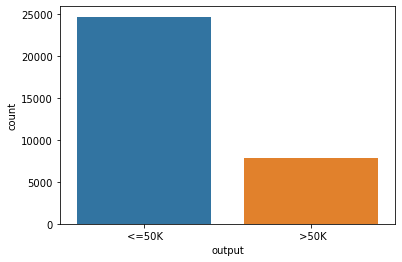

In [8]:
sns.countplot(x="output", data=data)

There is a gap between the number of persons who make >50k/year vs the number of persons who do not - Class imbalance at play here, makes it a challenging problem.

In [9]:
categorical_vars =["workclass", "education", "marital-status", "occupation", "relationship", 
                   "race", "sex", "native-country"]
df = data.copy()
for var in categorical_vars:
    df[var] = pd.Categorical(df[var])
    df[var] = df[var].cat.codes

continuous_vars = ["fnlwgt", "capital-gain", "capital-loss"]
for var in continuous_vars:
    df[var] = (df[var]-df[var].mean())/df[var].std()

y = df.output.values
X = df.drop(['output'], axis=1)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,output
0,39,7,-1.063594,9,13,4,1,1,4,1,0.148451,-0.216656,40,39,<=50K
1,50,6,-1.008692,9,13,2,4,0,4,1,-0.145918,-0.216656,13,39,<=50K
2,38,4,0.245075,11,9,0,6,1,4,1,-0.145918,-0.216656,40,39,<=50K
3,53,4,0.425795,1,7,2,6,0,2,1,-0.145918,-0.216656,40,39,<=50K
4,28,4,1.408154,9,13,2,10,5,2,0,-0.145918,-0.216656,40,5,<=50K


Now let us call the training function and take a look at the results. 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)
dt = dt_train(X_train, y_train, balance="balanced")

Now let us measure the performance of the model on the test set:

In [11]:
print("Score:", get_classification_score(dt, X_test, y_test))
print("F1-Score (Macro):",get_f1_score(dt, X_test, y_test))

Score: 0.8179026562260096
F1-Score (Macro): 0.751701479295647


As there are too much of negative examples, it is important to see confusion matrix to measure the actual model performance. 

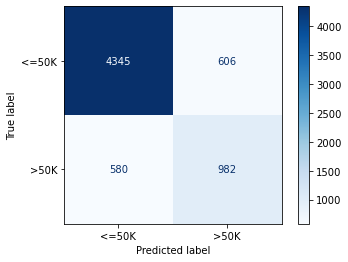

In [12]:
plot_confusion_matrix(dt, X_test, y_test,
                                 display_labels=['<=50K', '>50K'],
                                 cmap=plt.cm.Blues)
plt.show()

With the above model, it can be seen that the model does not fit well to positive examples. Now let us plot the learning curve.
As we have class imbalance here, let us use F1 Score Macro, which is the average of positive class score and the negative class score as the scorer for the learning curve plotter.

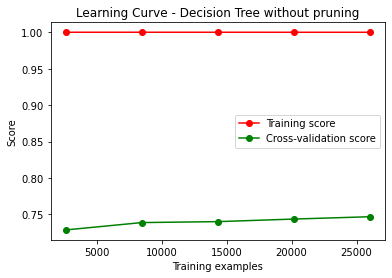

In [13]:
fig, ax = plt.subplots()
ax.set_title("Learning Curve - Decision Tree without pruning")
ax.set_xlabel("Training examples")
ax.set_ylabel("Score")

train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(dt, X, y, cv=5,
                       return_times=True, scoring=lambda dt, x, y: get_f1_score(dt, x, y))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
ax.legend(loc="best")


The wide difference between the training score and the CV score (F1-Macro) indicates that model overfits the training data. 
### Post Pruning
One way to deal with this is allow the model to overfit the data and perform post pruning.

[0.00000000e+00 1.62042921e-20 1.62042921e-20 ... 5.08543877e-02
 5.56687213e-02 1.59853539e-01]


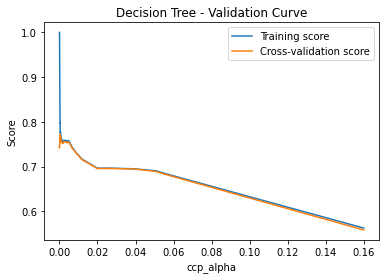

In [47]:
dt_final = dt_train(X_train, y_train, balance='balanced')
path = prune(dt_final, X_train, y_train)
ccp_alphas = path.ccp_alphas
print(ccp_alphas)
param_name = 'ccp_alpha'
validation_score = plot_validation_curve(dt_final,
                      X_train, y_train, param_name, ccp_alphas, cross_validation=5, fig_name="validation_curve.png",
                      xscale='linear', scorer=lambda dt, x, y: get_f1_score(dt, x, y))

In [53]:
dt_f = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alphas[np.argmax(validation_score)])
dt_f.fit(X_train, y_train)
get_f1_score(dt_f, X_test, y_test)

0.7819755764441231

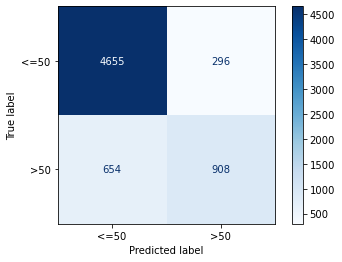

In [54]:
plot_confusion_matrix(dt_f, X_test, y_test,
                                 display_labels=['<=50', '>50'],
                                 cmap=plt.cm.Blues)
plt.show()

F1 Score for this model is better than that of the previous model

### Pre-pruning
Another way to avoid large decision trees that overfit the data is to prevent the nodes from being created using certain criteria.

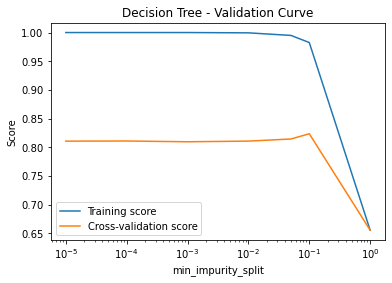

array([0.81061878, 0.81088748, 0.80954385, 0.81069555, 0.81438098,
       0.82351797, 0.65539348])

In [57]:
plot_validation_curve(tree.DecisionTreeClassifier(class_weight="balanced"),
                      X_train, y_train,
                      "min_impurity_split", [0.00001, 0.0001, 0.001,  0.01, 0.05, 0.1, 1.0], xscale='log')

Let us select 0.05 as the min_impurity_split value as it performs decently in both training and validation set

In [62]:
dt_pre = dt_train(X_train, y_train, min_impurity_split=0.05, class_weight='balanced')

print("Score: ", get_classification_score(dt_pre, X_test, y_test))
print("F1 Score: ", get_f1_score(dt_pre, X_test, y_test))

Score:  0.8245048364808844
F1 Score:  0.7617820747095898


Another way to pre-prune is to limit the max-depth of the decision tree being formed

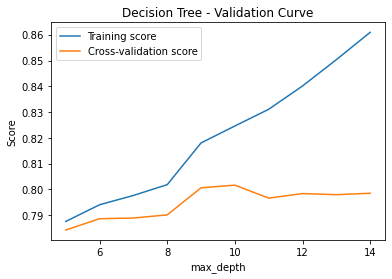

array([0.78428326, 0.78865998, 0.78892848, 0.79015705, 0.80063747,
       0.80167374, 0.79664496, 0.79841089, 0.79798811, 0.79852575])

In [61]:
plot_validation_curve(tree.DecisionTreeClassifier(class_weight="balanced"), X_train, y_train, 'max_depth', range(5, 15), 
                      fig_name="max_depth_vc.png")

In [67]:
dt_md = dt_train(X_train, y_train, max_depth=10, class_weight='balanced')

print("Score: ", get_classification_score(dt_pre, X_test, y_test))
print("F1 Score: ", get_f1_score(dt_pre, X_test, y_test))

Score:  0.8245048364808844
F1 Score:  0.7617820747095898


max_depth=10 has been found to perform well. Now let us plot the confusion matrix for both the pre-pruned models. 

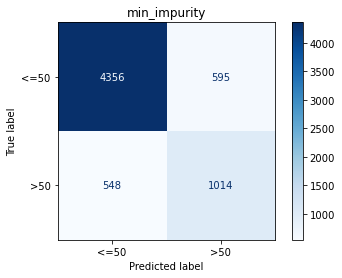

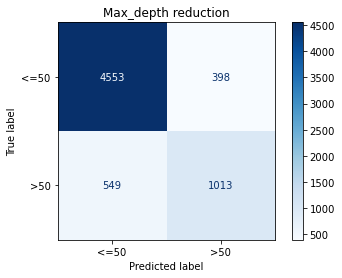

In [76]:
ax = plot_confusion_matrix(dt_pre, X_test, y_test,
                                 display_labels=['<=50', '>50'],
                                 cmap=plt.cm.Blues)
ax.ax_.set_title("min_impurity")
plt.show()

ax = plot_confusion_matrix(dt_train(X_train, y_train, class_weight='balanced', max_depth=10), X_test, y_test,
                                 display_labels=['<=50', '>50'],
                                 cmap=plt.cm.Blues)
ax.ax_.set_title("Max_depth reduction")
plt.show()

Now let us draw a final comparison between all the models by plotting an ROC curve. 

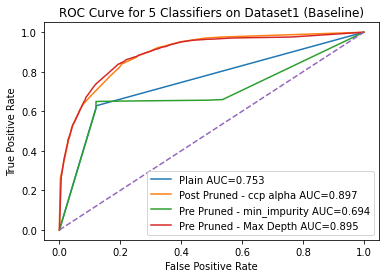

In [101]:
results = []
for name, d_tree in [("Plain", dt), ("Post Pruned - ccp alpha", dt_f), ("Pre Pruned - min_impurity", dt_pre),
                      ("Pre Pruned - Max Depth", dt_md)]:
    fpr, tpr, _ = metrics.roc_curve(y_test, d_tree.predict_proba(X_test)[:, 1], pos_label=" >50K")
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label=name + " AUC={:.3f}".format(auc))

plt.plot([0, 1], [0, 1],linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for 5 Classifiers on Dataset1 (Baseline)')
plt.legend(loc="best")
plt.show()


Of these models, post-pruned decision tree is found to have a better AUC value and hence, is the best model. 

In [102]:
import pickle
pickle.dump(dt_f, open("Decision Tree Post Pruned.sav", 'wb'))

# Phishing Dataset Analysis

The dataset aims to identify phishing websites based on various attributes. 

In [103]:
from scipy.io.arff import loadarff 

raw_data = loadarff('Training Dataset.arff')
ph_data = pd.DataFrame(raw_data[0])
ph_data.head()

for var in ph_data.columns.values:
    ph_data[var] = pd.Categorical(ph_data[var])
    ph_data[var] = ph_data[var].cat.codes

<AxesSubplot:xlabel='Result', ylabel='count'>

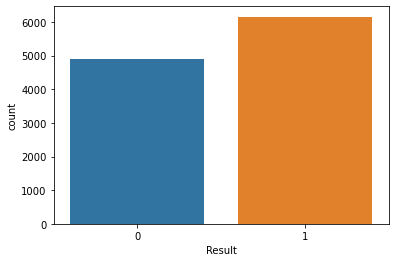

In [104]:
sns.countplot(x="Result", data=ph_data)

There is no class-imbalance like the previous dataset and hence we can use the normal score instead of f1 score. 

In [105]:
y = ph_data.Result.values
X = ph_data.drop(['Result'], axis=1)

Now let us train the model and look at the performance

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)
dt = dt_train(X_train, y_train)

In [109]:
print("Score:", get_classification_score(dt, X_test, y_test))

Score: 0.9710538218000905


Time to look at the confusion matrix.

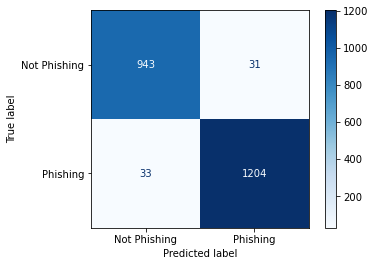

In [110]:
plot_confusion_matrix(dt, X_test, y_test,
                                 display_labels=['Not Phishing', 'Phishing'],
                                 cmap=plt.cm.Blues)
plt.show()

From the confusion matrix, we can infer that the decision tree model does justice to both the classes. 

As there isn't a noticeable class imbalance, f1 score analysis is not required. 


### Post-pruning
Now, let us take a look at the performance of DT with post-pruning on the phising websites dataset.

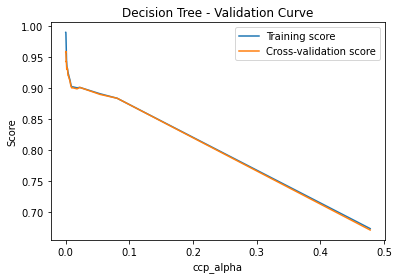

In [114]:
dt_final = dt_train(X_train, y_train)
path = prune(dt_final, X_train, y_train)
ccp_alphas = path.ccp_alphas
param_name = 'ccp_alpha'
validation_score = plot_validation_curve(dt_final,
                      X_train, y_train, param_name, ccp_alphas, cross_validation=5, fig_name="validation_curve.png",
                      xscale='linear', scorer=lambda dt, x, y: get_f1_score(dt, x, y))

In [117]:
dt_f = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alphas[np.argmax(validation_score)])
dt_f.fit(X_train, y_train)
dt_f.score(X_test, y_test)

0.9642695612844867

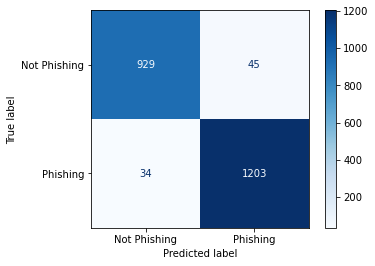

In [126]:
plot_confusion_matrix(dt_f, X_test, y_test,
                                 display_labels=['Not Phishing', 'Phishing'],
                                 cmap=plt.cm.Blues)
plt.show()

### Pre-pruning

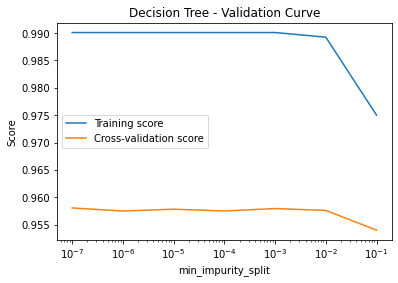

array([0.95805118, 0.95748576, 0.957825  , 0.9574857 , 0.95793799,
       0.95759882, 0.95398006])

In [120]:
plot_validation_curve(tree.DecisionTreeClassifier(),
                      X_train, y_train,
                      "min_impurity_split", [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1], xscale='log')

10^-3 works the est for min_impurity_split. Let us measure the actual performance of pre-pruning. 

In [121]:
dt_pre = dt_train(X_train, y_train, min_impurity_split=0.001)

print("Score: ", get_classification_score(dt_pre, X_test, y_test))
print("F1 Score: ", get_f1_score(dt_pre, X_test, y_test))

Score:  0.9710538218000905
F1 Score:  0.9706447597709733


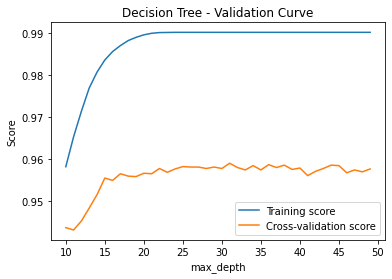

In [124]:
validation_score = plot_validation_curve(tree.DecisionTreeClassifier(), X_train, y_train, 'max_depth', range(10, 50), 
                      fig_name="max_depth_vc.png")

max_depth=31 works well among all the max_depth values. 

In [131]:
dt_md = dt_train(X_train, y_train, max_depth=31)

print("Score: ", get_classification_score(dt_md, X_test, y_test))
print("F1 Score: ", get_f1_score(dt_md, X_test, y_test))

Score:  0.9710538218000905
F1 Score:  0.9706447597709733


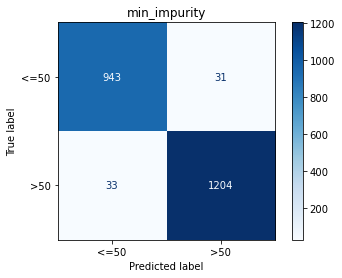

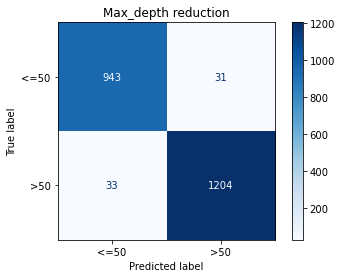

In [132]:
ax = plot_confusion_matrix(dt_pre, X_test, y_test,
                                 display_labels=['<=50', '>50'],
                                 cmap=plt.cm.Blues)
ax.ax_.set_title("min_impurity")
plt.show()

ax = plot_confusion_matrix(dt_md, X_test, y_test,
                                 display_labels=['<=50', '>50'],
                                 cmap=plt.cm.Blues)
ax.ax_.set_title("Max_depth reduction")
plt.show()

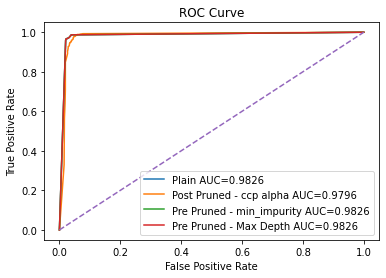

In [135]:
results = []
for name, d_tree in [("Plain", dt), ("Post Pruned - ccp alpha", dt_f), ("Pre Pruned - min_impurity", dt_pre),
                      ("Pre Pruned - Max Depth", dt_md)]:
    fpr, tpr, _ = metrics.roc_curve(y_test, d_tree.predict_proba(X_test)[:, 1], pos_label=1)
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label=name + " AUC={:.4f}".format(auc))

plt.plot([0, 1], [0, 1],linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="best")
plt.show()

In [136]:
pickle.dump(dt_md, open("Decision Tree Max Depth Dataset 2.sav", 'wb'))